# Notebook 05: Hybrid Fusion Model - Combining GNN and LSTM Embeddings

## Overview

This notebook implements the **fusion layer** that combines:
1. **GNN embeddings** from graph-based fraud detection (Notebook 03)
2. **LSTM embeddings** from sequential transaction patterns (Notebook 04)

### Architecture Pipeline

```
Transaction Graph        Transaction Sequences
       ↓                          ↓
   GNN Model                  LSTM Model
       ↓                          ↓
  GNN Embeddings           LSTM Embeddings
       ↓                          ↓
       └──────────┬───────────────┘
                  ↓
           Fusion Network
           (Multi-layer MLP)
                  ↓
        Fraud/Legit Prediction
```

### Key Features

- **Multi-modal fusion** with attention-based weighting
- **Advanced architectures**: Deep fusion, gated fusion, cross-modal attention
- **Comprehensive evaluation**: Comparison with individual models
- **Kaggle-optimized**: Session management and checkpoint persistence

In [1]:
# Environment detection and setup
import os
import sys
from pathlib import Path

RUNNING_ON_KAGGLE = 'KAGGLE_KERNEL_RUN_TYPE' in os.environ

print(f"🔍 Running on Kaggle: {RUNNING_ON_KAGGLE}")
print(f"🐍 Python version: {sys.version}")

if RUNNING_ON_KAGGLE:
    print("📦 Kaggle environment - packages pre-installed")
else:
    print("📦 Local environment")

print("✅ Environment setup complete")

🔍 Running on Kaggle: False
🐍 Python version: 3.12.4 (tags/v3.12.4:8e8a4ba, Jun  6 2024, 19:30:16) [MSC v.1940 64 bit (AMD64)]
📦 Local environment
✅ Environment setup complete


✅ NumPy: 1.26.4
✅ Matplotlib: 3.8.3
✅ PyTorch: 2.9.0+cpu


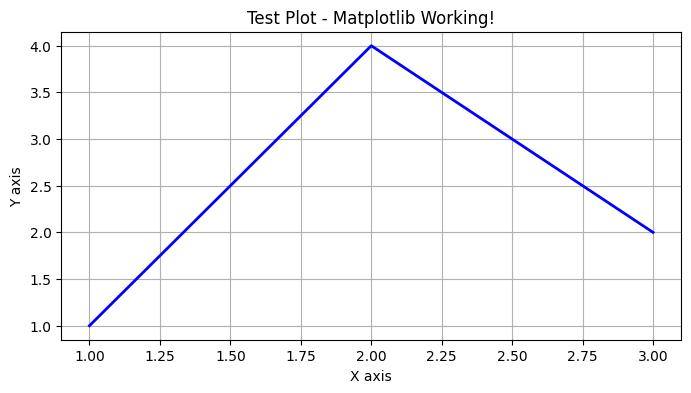

🎉 All imports and functionality working!


In [2]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import torch

print(f"✅ NumPy: {np.__version__}")
print(f"✅ Matplotlib: {matplotlib.__version__}")
print(f"✅ PyTorch: {torch.__version__}")

# Test actual plotting functionality
plt.figure(figsize=(8, 4))
plt.plot([1, 2, 3], [1, 4, 2], 'b-', linewidth=2)
plt.title("Test Plot - Matplotlib Working!")
plt.xlabel("X axis")
plt.ylabel("Y axis")
plt.grid(True)
plt.show()

print("🎉 All imports and functionality working!")

In [3]:
# Core imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
import pickle
import warnings
from typing import Dict, List, Tuple, Optional
import time
from tqdm.auto import tqdm
import gc

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torch.cuda.amp import autocast, GradScaler

# Metrics
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, confusion_matrix,
    classification_report, average_precision_score
)

warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print(f'PyTorch version: {torch.__version__}')
print(f'CUDA available: {torch.cuda.is_available()}')
if torch.cuda.is_available():
    print(f'GPU: {torch.cuda.get_device_name(0)}')
    print(f'CUDA version: {torch.version.cuda}')

PyTorch version: 2.9.0+cpu
CUDA available: False


## Path Configuration

In [4]:
# Configure paths based on environment
if RUNNING_ON_KAGGLE:
    BASE_PATH = Path('/kaggle/input/flag-finance')
    WORKING_ROOT = Path('/kaggle/working')
    DATA_PATH = BASE_PATH / 'data'

    # Input paths (read-only)
    processed_candidates = [
        DATA_PATH / 'processed',
        BASE_PATH / 'processed',
        BASE_PATH / 'processed' / 'processed'
    ]
    PROCESSED_PATH = next((p for p in processed_candidates if p.exists()), processed_candidates[-1])
    GNN_MODELS_PATH = DATA_PATH / 'models'
    LSTM_MODELS_PATH = DATA_PATH / 'models'

    # Output paths (writable)
    MODELS_PATH = WORKING_ROOT / 'models'
    RESULTS_PATH = WORKING_ROOT / 'results'
else:
    BASE_PATH = Path(r'C:\Users\youss\Downloads\Flag_finance')
    WORKING_ROOT = BASE_PATH
    DATA_PATH = BASE_PATH / 'data'

    PROCESSED_PATH = DATA_PATH / 'processed'
    GNN_MODELS_PATH = DATA_PATH / 'models'
    LSTM_MODELS_PATH = DATA_PATH / 'models'
    MODELS_PATH = DATA_PATH / 'models'
    RESULTS_PATH = DATA_PATH / 'results'

# Create output directories
MODELS_PATH.mkdir(exist_ok=True, parents=True)
RESULTS_PATH.mkdir(exist_ok=True, parents=True)

print(f'📁 Path Configuration:')
print(f'   Base path: {BASE_PATH}')
print(f'   Data root: {DATA_PATH}')
print(f'   Processed data: {PROCESSED_PATH}')
print(f'   Models directory: {GNN_MODELS_PATH}')
print(f'   Results output: {RESULTS_PATH}')

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'\n🔧 Device: {device}')

📁 Path Configuration:
   Base path: C:\Users\youss\Downloads\Flag_finance
   Data root: C:\Users\youss\Downloads\Flag_finance\data
   Processed data: C:\Users\youss\Downloads\Flag_finance\data\processed
   Models directory: C:\Users\youss\Downloads\Flag_finance\data\models
   Results output: C:\Users\youss\Downloads\Flag_finance\data\results

🔧 Device: cpu


## Load Embeddings from Previous Notebooks

In [5]:
print('='*70)
print('LOADING GNN AND LSTM EMBEDDINGS')
print('='*70)

# Helper to locate files across candidate paths
def _locate_file(filename: str, candidates: List[Path]) -> Optional[Path]:
    for candidate in candidates:
        if candidate.exists():
            return candidate
    return None

# Locate GNN embeddings
_gnn_candidates = [
    PROCESSED_PATH / 'gnn_embeddings.pkl',
    DATA_PATH / 'gnn_embeddings.pkl',
    WORKING_ROOT / 'gnn_embeddings.pkl',
    GNN_MODELS_PATH / 'gnn_embeddings.pkl'
]

gnn_embeddings_file = _locate_file('gnn_embeddings.pkl', _gnn_candidates)

if gnn_embeddings_file is not None:
    with open(gnn_embeddings_file, 'rb') as f:
        gnn_embeddings_dict = pickle.load(f)
    print(f'\n✅ Loaded GNN embeddings from: {gnn_embeddings_file}')
    print(f'   Available models: {list(gnn_embeddings_dict.keys())}')
else:
    searched_paths = '\n'.join([f'   - {path}' for path in _gnn_candidates])
    raise FileNotFoundError(
        'GNN embeddings not found. Looked in:\n'
        f'{searched_paths}\n'
        'Please run Notebook 03 first or place gnn_embeddings.pkl in one of these folders.'
    )

# Locate LSTM embeddings
_lstm_candidates = [
    PROCESSED_PATH / 'lstm_embeddings.pkl',
    DATA_PATH / 'lstm_embeddings.pkl',
    WORKING_ROOT / 'lstm_embeddings.pkl',
    LSTM_MODELS_PATH / 'lstm_embeddings.pkl'
]

lstm_embeddings_file = _locate_file('lstm_embeddings.pkl', _lstm_candidates)

if lstm_embeddings_file is not None:
    with open(lstm_embeddings_file, 'rb') as f:
        lstm_embeddings_dict = pickle.load(f)
    print(f'\n✅ Loaded LSTM embeddings from: {lstm_embeddings_file}')
    print(f'   Available models: {list(lstm_embeddings_dict.keys())}')
else:
    searched_paths = '\n'.join([f'   - {path}' for path in _lstm_candidates])
    raise FileNotFoundError(
        'LSTM embeddings not found. Looked in:\n'
        f'{searched_paths}\n'
        'Please run Notebook 04 first or place lstm_embeddings.pkl in one of these folders.'
    )

LOADING GNN AND LSTM EMBEDDINGS

✅ Loaded GNN embeddings from: C:\Users\youss\Downloads\Flag_finance\data\gnn_embeddings.pkl
   Available models: ['HybridGNN_L4_H320']

✅ Loaded LSTM embeddings from: C:\Users\youss\Downloads\Flag_finance\data\lstm_embeddings.pkl
   Available models: ['BiLSTM_Attention', 'ResidualGRU', 'LSTM_CNN_Hybrid']


In [6]:
# Select best models from each modality
# Override defaults based on available assets from TREE_STRUCTURE
PREFERRED_GNN_MODEL = 'HybridGNN_L4_H320'
PREFERRED_LSTM_MODEL = 'LSTM_CNN_Hybrid'

gnn_available = list(gnn_embeddings_dict.keys())
lstm_available = list(lstm_embeddings_dict.keys())

SELECTED_GNN_MODEL = (
    PREFERRED_GNN_MODEL if PREFERRED_GNN_MODEL in gnn_available else gnn_available[0]
)
SELECTED_LSTM_MODEL = (
    PREFERRED_LSTM_MODEL if PREFERRED_LSTM_MODEL in lstm_available else lstm_available[0]
)

if SELECTED_GNN_MODEL != PREFERRED_GNN_MODEL:
    print(f'⚠️ Preferred GNN model "{PREFERRED_GNN_MODEL}" not found. Using {SELECTED_GNN_MODEL} instead.')
if SELECTED_LSTM_MODEL != PREFERRED_LSTM_MODEL:
    print(f'⚠️ Preferred LSTM model "{PREFERRED_LSTM_MODEL}" not found. Using {SELECTED_LSTM_MODEL} instead.')

print(f'\n🎯 Selected Models for Fusion:')
print(f'   GNN Model: {SELECTED_GNN_MODEL}')
print(f'   LSTM Model: {SELECTED_LSTM_MODEL}')

# Extract embeddings and labels
gnn_data = gnn_embeddings_dict[SELECTED_GNN_MODEL]
lstm_data = lstm_embeddings_dict[SELECTED_LSTM_MODEL]

# Prepare data splits
splits = ['train', 'val', 'test']
fusion_data = {}

for split in splits:
    gnn_emb = gnn_data[split]['embeddings']
    lstm_emb = lstm_data[split]['embeddings']
    labels = gnn_data[split]['labels']
    
    # Ensure same number of samples
    min_samples = min(len(gnn_emb), len(lstm_emb))
    gnn_emb = gnn_emb[:min_samples]
    lstm_emb = lstm_emb[:min_samples]
    labels = labels[:min_samples]
    
    fusion_data[split] = {
        'gnn_embeddings': gnn_emb,
        'lstm_embeddings': lstm_emb,
        'labels': labels
    }
    
    print(f'\n{split.upper()} set:')
    print(f'   GNN embeddings: {gnn_emb.shape}')
    print(f'   LSTM embeddings: {lstm_emb.shape}')
    print(f'   Labels: {labels.shape}')
    print(f'   Fraud rate: {labels.mean()*100:.2f}%')

GNN_EMB_DIM = fusion_data['train']['gnn_embeddings'].shape[1]
LSTM_EMB_DIM = fusion_data['train']['lstm_embeddings'].shape[1]

print(f'\n📊 Embedding Dimensions:')
print(f'   GNN: {GNN_EMB_DIM}')
print(f'   LSTM: {LSTM_EMB_DIM}')
print(f'   Combined: {GNN_EMB_DIM + LSTM_EMB_DIM}')


🎯 Selected Models for Fusion:
   GNN Model: HybridGNN_L4_H320
   LSTM Model: LSTM_CNN_Hybrid

TRAIN set:
   GNN embeddings: (4498, 320)
   LSTM embeddings: (4498, 256)
   Labels: (4498,)
   Fraud rate: 26.97%

VAL set:
   GNN embeddings: (1125, 320)
   LSTM embeddings: (1125, 256)
   Labels: (1125,)
   Fraud rate: 23.29%

TEST set:
   GNN embeddings: (1406, 320)
   LSTM embeddings: (1406, 256)
   Labels: (1406,)
   Fraud rate: 37.55%

📊 Embedding Dimensions:
   GNN: 320
   LSTM: 256
   Combined: 576


## Fusion Dataset and DataLoaders

In [7]:
class FusionDataset(Dataset):
    """Dataset for fusion model combining GNN and LSTM embeddings."""
    
    def __init__(self, gnn_embeddings, lstm_embeddings, labels):
        self.gnn_embeddings = torch.FloatTensor(gnn_embeddings)
        self.lstm_embeddings = torch.FloatTensor(lstm_embeddings)
        self.labels = torch.LongTensor(labels)
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        return (
            self.gnn_embeddings[idx],
            self.lstm_embeddings[idx],
            self.labels[idx]
        )
    
    def get_class_weights(self):
        """Compute class weights for balanced training."""
        labels_np = self.labels.numpy()
        class_counts = np.bincount(labels_np)
        weights = 1.0 / class_counts
        weights = weights / weights.sum() * len(weights)
        return torch.FloatTensor(weights)

# Create datasets
train_dataset = FusionDataset(
    fusion_data['train']['gnn_embeddings'],
    fusion_data['train']['lstm_embeddings'],
    fusion_data['train']['labels']
)

val_dataset = FusionDataset(
    fusion_data['val']['gnn_embeddings'],
    fusion_data['val']['lstm_embeddings'],
    fusion_data['val']['labels']
)

test_dataset = FusionDataset(
    fusion_data['test']['gnn_embeddings'],
    fusion_data['test']['lstm_embeddings'],
    fusion_data['test']['labels']
)

# Create data loaders
BATCH_SIZE = 256

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=0,
    pin_memory=True if torch.cuda.is_available() else False
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0,
    pin_memory=True if torch.cuda.is_available() else False
)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0,
    pin_memory=True if torch.cuda.is_available() else False
)

print('✅ Fusion datasets and dataloaders created')
print(f'   Batch size: {BATCH_SIZE}')
print(f'   Train batches: {len(train_loader)}')
print(f'   Val batches: {len(val_loader)}')
print(f'   Test batches: {len(test_loader)}')

✅ Fusion datasets and dataloaders created
   Batch size: 256
   Train batches: 18
   Val batches: 5
   Test batches: 6


## Fusion Model Architectures

We implement three fusion strategies:

1. **SimpleFusion**: Concatenation + MLP
2. **AttentionFusion**: Learned attention weights for each modality
3. **GatedFusion**: Gating mechanism to control information flow
4. **CrossModalFusion**: Cross-attention between modalities

In [8]:
class SimpleFusion(nn.Module):
    """Simple concatenation-based fusion."""
    
    def __init__(self, gnn_dim, lstm_dim, hidden_dim=256, num_classes=2, dropout=0.4):
        super().__init__()
        input_dim = gnn_dim + lstm_dim
        
        self.fusion = nn.Sequential(
            nn.Linear(input_dim, hidden_dim * 2),
            nn.BatchNorm1d(hidden_dim * 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout * 0.7),
            
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.BatchNorm1d(hidden_dim // 2),
            nn.ReLU(),
            nn.Dropout(dropout * 0.5),
            
            nn.Linear(hidden_dim // 2, num_classes)
        )
        self._init_weights()
    
    def _init_weights(self):
        for module in self.modules():
            if isinstance(module, nn.Linear):
                nn.init.kaiming_normal_(module.weight, nonlinearity='relu')
                if module.bias is not None:
                    nn.init.zeros_(module.bias)
    
    def forward(self, gnn_emb, lstm_emb):
        combined = torch.cat([gnn_emb, lstm_emb], dim=1)
        return self.fusion(combined)


class AttentionFusion(nn.Module):
    """Fusion with learned attention weights for each modality."""
    
    def __init__(self, gnn_dim, lstm_dim, hidden_dim=256, num_classes=2, dropout=0.4):
        super().__init__()
        self.gnn_proj = nn.Sequential(
            nn.Linear(gnn_dim, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.ReLU()
        )
        self.lstm_proj = nn.Sequential(
            nn.Linear(lstm_dim, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.ReLU()
        )
        self.attention = nn.Sequential(
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, 2),
            nn.Softmax(dim=1)
        )
        self.classifier = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.BatchNorm1d(hidden_dim // 2),
            nn.ReLU(),
            nn.Dropout(dropout * 0.7),
            
            nn.Linear(hidden_dim // 2, num_classes)
        )
        self._init_weights()
    
    def _init_weights(self):
        for module in self.modules():
            if isinstance(module, nn.Linear):
                nn.init.xavier_uniform_(module.weight)
                if module.bias is not None:
                    nn.init.zeros_(module.bias)
    
    def forward(self, gnn_emb, lstm_emb):
        gnn_proj = self.gnn_proj(gnn_emb)
        lstm_proj = self.lstm_proj(lstm_emb)
        combined = torch.cat([gnn_proj, lstm_proj], dim=1)
        attn_weights = self.attention(combined)
        gnn_weighted = gnn_proj * attn_weights[:, 0:1]
        lstm_weighted = lstm_proj * attn_weights[:, 1:2]
        fused = gnn_weighted + lstm_weighted
        return self.classifier(fused)


class GatedFusion(nn.Module):
    """Gated fusion with learned gating mechanism."""
    
    def __init__(self, gnn_dim, lstm_dim, hidden_dim=256, num_classes=2, dropout=0.4):
        super().__init__()
        self.gnn_proj = nn.Sequential(
            nn.Linear(gnn_dim, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.ReLU()
        )
        self.lstm_proj = nn.Sequential(
            nn.Linear(lstm_dim, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.ReLU()
        )
        self.gate = nn.Sequential(
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.Sigmoid()
        )
        self.classifier = nn.Sequential(
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.BatchNorm1d(hidden_dim // 2),
            nn.ReLU(),
            nn.Dropout(dropout * 0.7),
            
            nn.Linear(hidden_dim // 2, num_classes)
        )
        self._init_weights()
    
    def _init_weights(self):
        for module in self.modules():
            if isinstance(module, nn.Linear):
                nn.init.xavier_uniform_(module.weight)
                if module.bias is not None:
                    nn.init.zeros_(module.bias)
    
    def forward(self, gnn_emb, lstm_emb):
        gnn_proj = self.gnn_proj(gnn_emb)
        lstm_proj = self.lstm_proj(lstm_emb)
        combined = torch.cat([gnn_proj, lstm_proj], dim=1)
        gate = self.gate(combined)
        gnn_gated = gnn_proj * gate
        lstm_gated = lstm_proj * (1 - gate)
        fused = torch.cat([gnn_gated, lstm_gated], dim=1)
        return self.classifier(fused)


class CrossModalFusion(nn.Module):
    """Cross-modal attention fusion."""
    
    def __init__(self, gnn_dim, lstm_dim, hidden_dim=256, num_classes=2, dropout=0.4):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.gnn_proj = nn.Sequential(
            nn.Linear(gnn_dim, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.ReLU()
        )
        self.lstm_proj = nn.Sequential(
            nn.Linear(lstm_dim, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.ReLU()
        )
        self.gnn_to_lstm_attn = nn.MultiheadAttention(
            embed_dim=hidden_dim, num_heads=4, dropout=dropout, batch_first=True
        )
        self.lstm_to_gnn_attn = nn.MultiheadAttention(
            embed_dim=hidden_dim, num_heads=4, dropout=dropout, batch_first=True
        )
        self.ffn = nn.Sequential(
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, hidden_dim)
        )
        self.classifier = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.BatchNorm1d(hidden_dim // 2),
            nn.ReLU(),
            nn.Dropout(dropout * 0.7),
            nn.Linear(hidden_dim // 2, num_classes)
        )
        self._init_weights()
    
    def _init_weights(self):
        for module in self.modules():
            if isinstance(module, nn.Linear):
                nn.init.xavier_uniform_(module.weight)
                if module.bias is not None:
                    nn.init.zeros_(module.bias)
    
    def forward(self, gnn_emb, lstm_emb):
        batch_size = gnn_emb.size(0)
        gnn_proj = self.gnn_proj(gnn_emb).unsqueeze(1)
        lstm_proj = self.lstm_proj(lstm_emb).unsqueeze(1)
        
        lstm_to_gnn, _ = self.lstm_to_gnn_attn(gnn_proj, lstm_proj, lstm_proj)
        gnn_to_lstm, _ = self.gnn_to_lstm_attn(lstm_proj, gnn_proj, gnn_proj)
        fused = torch.cat([lstm_to_gnn.squeeze(1), gnn_to_lstm.squeeze(1)], dim=1)
        fused = self.ffn(fused)
        return self.classifier(fused)

## Fusion Model Architectures

We implement four fusion strategies:

1. **SimpleFusion**: Concatenation + MLP
2. **AttentionFusion**: Learned attention weights for each modality
3. **GatedFusion**: Gating mechanism to control information flow
4. **CrossModalFusion**: Cross-attention between modalities

In [9]:
class SimpleFusion(nn.Module):
    """Simple concatenation-based fusion."""
    
    def __init__(self, gnn_dim, lstm_dim, hidden_dim=256, num_classes=2, dropout=0.4):
        super().__init__()
        
        input_dim = gnn_dim + lstm_dim
        
        self.fusion = nn.Sequential(
            nn.Linear(input_dim, hidden_dim * 2),
            nn.BatchNorm1d(hidden_dim * 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout * 0.7),
            
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.BatchNorm1d(hidden_dim // 2),
            nn.ReLU(),
            nn.Dropout(dropout * 0.5),
            
            nn.Linear(hidden_dim // 2, num_classes)
        )
        
        self._init_weights()
    
    def _init_weights(self):
        for module in self.modules():
            if isinstance(module, nn.Linear):
                nn.init.kaiming_normal_(module.weight, nonlinearity='relu')
                if module.bias is not None:
                    nn.init.zeros_(module.bias)
    
    def forward(self, gnn_emb, lstm_emb):
        combined = torch.cat([gnn_emb, lstm_emb], dim=1)
        return self.fusion(combined)


def _init_linear_weights(module):
    if isinstance(module, nn.Linear):
        nn.init.xavier_uniform_(module.weight)
        if module.bias is not None:
            nn.init.zeros_(module.bias)


class AttentionFusion(nn.Module):
    """Fusion with learned attention weights for each modality."""
    
    def __init__(self, gnn_dim, lstm_dim, hidden_dim=256, num_classes=2, dropout=0.4):
        super().__init__()
        
        # Project embeddings to same dimension
        self.gnn_proj = nn.Sequential(
            nn.Linear(gnn_dim, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.ReLU()
        )
        
        self.lstm_proj = nn.Sequential(
            nn.Linear(lstm_dim, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.ReLU()
        )
        
        # Attention mechanism
        self.attention = nn.Sequential(
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, 2),
            nn.Softmax(dim=1)
        )
        
        # Classifier
        self.classifier = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.BatchNorm1d(hidden_dim // 2),
            nn.ReLU(),
            nn.Dropout(dropout * 0.7),
            
            nn.Linear(hidden_dim // 2, num_classes)
        )
        
        self.apply(_init_linear_weights)
    
    def forward(self, gnn_emb, lstm_emb):
        # Project to same dimension
        gnn_proj = self.gnn_proj(gnn_emb)
        lstm_proj = self.lstm_proj(lstm_emb)
        
        # Compute attention weights
        combined = torch.cat([gnn_proj, lstm_proj], dim=1)
        attn_weights = self.attention(combined)  # (batch_size, 2)
        
        # Apply attention
        gnn_weighted = gnn_proj * attn_weights[:, 0:1]
        lstm_weighted = lstm_proj * attn_weights[:, 1:2]
        
        # Fused representation
        fused = gnn_weighted + lstm_weighted
        
        return self.classifier(fused)


class GatedFusion(nn.Module):
    """Gated fusion with learned gating mechanism."""
    
    def __init__(self, gnn_dim, lstm_dim, hidden_dim=256, num_classes=2, dropout=0.4):
        super().__init__()
        
        # Project embeddings
        self.gnn_proj = nn.Sequential(
            nn.Linear(gnn_dim, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.ReLU()
        )
        
        self.lstm_proj = nn.Sequential(
            nn.Linear(lstm_dim, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.ReLU()
        )
        
        # Gating mechanism
        self.gate = nn.Sequential(
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.Sigmoid()
        )
        
        # Classifier
        self.classifier = nn.Sequential(
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.BatchNorm1d(hidden_dim // 2),
            nn.ReLU(),
            nn.Dropout(dropout * 0.7),
            
            nn.Linear(hidden_dim // 2, num_classes)
        )
        
        self.apply(_init_linear_weights)
    
    def forward(self, gnn_emb, lstm_emb):
        # Project embeddings
        gnn_proj = self.gnn_proj(gnn_emb)
        lstm_proj = self.lstm_proj(lstm_emb)
        
        # Compute gate
        combined = torch.cat([gnn_proj, lstm_proj], dim=1)
        gate = self.gate(combined)
        
        # Apply gating
        gnn_gated = gnn_proj * gate
        lstm_gated = lstm_proj * (1 - gate)
        
        # Concatenate and classify
        fused = torch.cat([gnn_gated, lstm_gated], dim=1)
        return self.classifier(fused)


class CrossModalFusion(nn.Module):
    """Cross-modal attention fusion."""
    
    def __init__(self, gnn_dim, lstm_dim, hidden_dim=256, num_classes=2, dropout=0.4, num_heads=4):
        super().__init__()
        
        # Project embeddings
        self.gnn_proj = nn.Sequential(
            nn.Linear(gnn_dim, hidden_dim),
            nn.LayerNorm(hidden_dim)
        )
        
        self.lstm_proj = nn.Sequential(
            nn.Linear(lstm_dim, hidden_dim),
            nn.LayerNorm(hidden_dim)
        )
        
        # Cross-attention: GNN -> LSTM
        self.gnn_to_lstm_attn = nn.MultiheadAttention(
            hidden_dim, num_heads=num_heads, dropout=dropout, batch_first=True
        )
        
        # Cross-attention: LSTM -> GNN
        self.lstm_to_gnn_attn = nn.MultiheadAttention(
            hidden_dim, num_heads=num_heads, dropout=dropout, batch_first=True
        )
        
        # Layer norms
        self.norm1 = nn.LayerNorm(hidden_dim)
        self.norm2 = nn.LayerNorm(hidden_dim)
        
        # Classifier
        self.classifier = nn.Sequential(
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.BatchNorm1d(hidden_dim // 2),
            nn.ReLU(),
            nn.Dropout(dropout * 0.7),
            
            nn.Linear(hidden_dim // 2, num_classes)
        )
        
        self.apply(_init_linear_weights)
    
    def forward(self, gnn_emb, lstm_emb):
        # Project embeddings
        gnn_proj = self.gnn_proj(gnn_emb).unsqueeze(1)  # (batch, 1, hidden)
        lstm_proj = self.lstm_proj(lstm_emb).unsqueeze(1)  # (batch, 1, hidden)
        
        # Cross-attention: GNN attends to LSTM
        gnn_attended, _ = self.gnn_to_lstm_attn(gnn_proj, lstm_proj, lstm_proj)
        gnn_attended = self.norm1(gnn_attended.squeeze(1) + gnn_proj.squeeze(1))
        
        # Cross-attention: LSTM attends to GNN
        lstm_attended, _ = self.lstm_to_gnn_attn(lstm_proj, gnn_proj, gnn_proj)
        lstm_attended = self.norm2(lstm_attended.squeeze(1) + lstm_proj.squeeze(1))
        
        # Concatenate and classify
        fused = torch.cat([gnn_attended, lstm_attended], dim=1)
        return self.classifier(fused)


print('✅ Fusion model architectures defined')

✅ Fusion model architectures defined


## Training Utilities

In [10]:
class FocalLoss(nn.Module):
    """Focal Loss for handling class imbalance."""
    
    def __init__(self, alpha=None, gamma=2.0):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
    
    def forward(self, inputs, targets):
        ce_loss = F.cross_entropy(inputs, targets, reduction='none', weight=self.alpha)
        pt = torch.exp(-ce_loss)
        focal_loss = ((1 - pt) ** self.gamma) * ce_loss
        return focal_loss.mean()


def train_epoch(model, loader, optimizer, criterion, scaler, device):
    """Train for one epoch."""
    model.train()
    total_loss = 0
    all_preds = []
    all_labels = []
    
    for gnn_emb, lstm_emb, labels in tqdm(loader, desc='Training', leave=False):
        gnn_emb = gnn_emb.to(device)
        lstm_emb = lstm_emb.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad(set_to_none=True)
        
        with autocast():
            outputs = model(gnn_emb, lstm_emb)
            loss = criterion(outputs, labels)
        
        scaler.scale(loss).backward()
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        scaler.step(optimizer)
        scaler.update()
        
        total_loss += loss.item() * gnn_emb.size(0)
        
        preds = outputs.argmax(dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
    
    avg_loss = total_loss / len(loader.dataset)
    accuracy = accuracy_score(all_labels, all_preds)
    
    return avg_loss, accuracy


@torch.no_grad()
def evaluate(model, loader, criterion, device):
    """Evaluate model."""
    model.eval()
    total_loss = 0
    all_preds = []
    all_probs = []
    all_labels = []
    
    for gnn_emb, lstm_emb, labels in tqdm(loader, desc='Evaluating', leave=False):
        gnn_emb = gnn_emb.to(device)
        lstm_emb = lstm_emb.to(device)
        labels = labels.to(device)
        
        outputs = model(gnn_emb, lstm_emb)
        loss = criterion(outputs, labels)
        
        total_loss += loss.item() * gnn_emb.size(0)
        
        probs = F.softmax(outputs, dim=1)
        preds = probs.argmax(dim=1)
        
        all_preds.extend(preds.cpu().numpy())
        all_probs.extend(probs[:, 1].cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
    
    avg_loss = total_loss / len(loader.dataset)
    
    all_preds = np.array(all_preds)
    all_probs = np.array(all_probs)
    all_labels = np.array(all_labels)
    
    metrics = {
        'loss': avg_loss,
        'accuracy': accuracy_score(all_labels, all_preds),
        'precision': precision_score(all_labels, all_preds, zero_division=0),
        'recall': recall_score(all_labels, all_preds, zero_division=0),
        'f1': f1_score(all_labels, all_preds, zero_division=0),
        'auc': roc_auc_score(all_labels, all_probs) if len(np.unique(all_labels)) > 1 else 0.0,
        'ap': average_precision_score(all_labels, all_probs) if len(np.unique(all_labels)) > 1 else 0.0
    }
    
    return metrics, all_preds, all_probs

print('✅ Training utilities defined')

✅ Training utilities defined


## Complete Training Loop

In [11]:
def train_fusion_model(model, train_loader, val_loader, test_loader, model_name,
                       epochs=100, lr=0.001, patience=15, device='cuda'):
    """Complete training loop for fusion models."""
    
    print(f'\n{"="*70}')
    print(f'Training {model_name}')
    print(f'{"="*70}')
    
    # Get class weights
    class_weights = train_loader.dataset.get_class_weights().to(device)
    criterion = FocalLoss(alpha=class_weights, gamma=2.5)
    
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-4)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
        optimizer, T_0=20, T_mult=2
    )
    scaler = GradScaler()
    
    best_val_f1 = 0
    patience_counter = 0
    history = {
        'train_loss': [], 'train_acc': [],
        'val_loss': [], 'val_acc': [], 'val_f1': [], 'val_auc': []
    }
    
    start_time = time.time()
    
    for epoch in range(1, epochs + 1):
        # Train
        train_loss, train_acc = train_epoch(
            model, train_loader, optimizer, criterion, scaler, device
        )
        
        # Validate
        val_metrics, _, _ = evaluate(model, val_loader, criterion, device)
        
        # Update scheduler
        scheduler.step()
        
        # Record history
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_metrics['loss'])
        history['val_acc'].append(val_metrics['accuracy'])
        history['val_f1'].append(val_metrics['f1'])
        history['val_auc'].append(val_metrics['auc'])
        
        # Print progress
        if epoch % 5 == 0 or epoch == 1:
            print(f'Epoch {epoch:03d}/{epochs} | '
                  f'Loss: {train_loss:.4f} | '
                  f'Val Acc: {val_metrics["accuracy"]:.4f} | '
                  f'Val F1: {val_metrics["f1"]:.4f} | '
                  f'Val AUC: {val_metrics["auc"]:.4f}')
        
        # Save best model
        if val_metrics['f1'] > best_val_f1:
            best_val_f1 = val_metrics['f1']
            patience_counter = 0
            
            checkpoint_path = MODELS_PATH / f'{model_name}_best.pt'
            torch.save({
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'epoch': epoch,
                'val_metrics': val_metrics
            }, checkpoint_path)
        else:
            patience_counter += 1
        
        # Early stopping
        if patience_counter >= patience:
            print(f'\n⏹️ Early stopping at epoch {epoch}')
            break
    
    train_time = time.time() - start_time
    
    # Load best model
    checkpoint = torch.load(MODELS_PATH / f'{model_name}_best.pt', weights_only=False)
    model.load_state_dict(checkpoint['model_state_dict'])
    
    # Test evaluation
    test_metrics, test_pred, test_prob = evaluate(model, test_loader, criterion, device)
    
    print(f'\n📊 Test Results:')
    print(f'   Accuracy: {test_metrics["accuracy"]:.4f}')
    print(f'   Precision: {test_metrics["precision"]:.4f}')
    print(f'   Recall: {test_metrics["recall"]:.4f}')
    print(f'   F1 Score: {test_metrics["f1"]:.4f}')
    print(f'   AUC: {test_metrics["auc"]:.4f}')
    print(f'   AP: {test_metrics["ap"]:.4f}')
    
    return {
        'model': model,
        'test_metrics': test_metrics,
        'train_time': float(train_time),
        'epochs': epoch,
        'history': history,
        'predictions': {'pred': test_pred.tolist(), 'prob': test_prob.tolist()}
    }

print('✅ Complete training function defined')

✅ Complete training function defined


## Train All Fusion Models

In [12]:
# Clear GPU memory
if torch.cuda.is_available():
    torch.cuda.empty_cache()
gc.collect()

# Model configurations
fusion_configs = [
    {
        'name': 'SimpleFusion',
        'model': SimpleFusion(GNN_EMB_DIM, LSTM_EMB_DIM, hidden_dim=256, dropout=0.4),
        'lr': 0.001,
        'epochs': 100
    },
    {
        'name': 'AttentionFusion',
        'model': AttentionFusion(GNN_EMB_DIM, LSTM_EMB_DIM, hidden_dim=256, dropout=0.4),
        'lr': 0.001,
        'epochs': 100
    },
    {
        'name': 'GatedFusion',
        'model': GatedFusion(GNN_EMB_DIM, LSTM_EMB_DIM, hidden_dim=256, dropout=0.4),
        'lr': 0.001,
        'epochs': 100
    },
    {
        'name': 'CrossModalFusion',
        'model': CrossModalFusion(GNN_EMB_DIM, LSTM_EMB_DIM, hidden_dim=256, dropout=0.4, num_heads=4),
        'lr': 0.001,
        'epochs': 100
    }
]

# Train all fusion models
fusion_results = {}

for config in fusion_configs:
    model_name = config['name']
    model = config['model'].to(device)
    
    # Count parameters
    num_params = sum(p.numel() for p in model.parameters())
    print(f'\n{model_name}: {num_params:,} parameters')
    
    # Train model
    result = train_fusion_model(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        test_loader=test_loader,
        model_name=model_name,
        epochs=config['epochs'],
        lr=config['lr'],
        patience=15,
        device=device
    )
    
    fusion_results[model_name] = result
    
    # Clear memory
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
    gc.collect()

print('\n' + '='*70)
print('✅ ALL FUSION MODELS TRAINED')
print('='*70)


SimpleFusion: 461,698 parameters

Training SimpleFusion


Training:   0%|          | 0/18 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 001/100 | Loss: 0.0707 | Val Acc: 0.8853 | Val F1: 0.7616 | Val AUC: 0.8960


Training:   0%|          | 0/18 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/18 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/18 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/18 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 005/100 | Loss: 0.0239 | Val Acc: 0.8782 | Val F1: 0.7468 | Val AUC: 0.8797


Training:   0%|          | 0/18 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/18 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/18 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/18 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/18 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 010/100 | Loss: 0.0143 | Val Acc: 0.8827 | Val F1: 0.7556 | Val AUC: 0.8837


Training:   0%|          | 0/18 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/18 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/18 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/18 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/18 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 015/100 | Loss: 0.0139 | Val Acc: 0.8836 | Val F1: 0.7579 | Val AUC: 0.8827


Training:   0%|          | 0/18 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]


⏹️ Early stopping at epoch 16


Evaluating:   0%|          | 0/6 [00:00<?, ?it/s]


📊 Test Results:
   Accuracy: 0.7482
   Precision: 0.7919
   Recall: 0.4470
   F1 Score: 0.5714
   AUC: 0.7494
   AP: 0.7033

AttentionFusion: 380,548 parameters

Training AttentionFusion


Training:   0%|          | 0/18 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 001/100 | Loss: 0.0750 | Val Acc: 0.8898 | Val F1: 0.7606 | Val AUC: 0.8718


Training:   0%|          | 0/18 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/18 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/18 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/18 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 005/100 | Loss: 0.0169 | Val Acc: 0.8809 | Val F1: 0.7546 | Val AUC: 0.8667


Training:   0%|          | 0/18 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/18 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/18 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/18 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/18 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 010/100 | Loss: 0.0114 | Val Acc: 0.8844 | Val F1: 0.7593 | Val AUC: 0.8587


Training:   0%|          | 0/18 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/18 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/18 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/18 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/18 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 015/100 | Loss: 0.0089 | Val Acc: 0.8853 | Val F1: 0.7607 | Val AUC: 0.8589


Training:   0%|          | 0/18 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/18 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/18 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/18 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/18 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 020/100 | Loss: 0.0089 | Val Acc: 0.8844 | Val F1: 0.7593 | Val AUC: 0.8572


Training:   0%|          | 0/18 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/18 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/18 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/18 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/18 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 025/100 | Loss: 0.0088 | Val Acc: 0.8800 | Val F1: 0.7523 | Val AUC: 0.8593


Training:   0%|          | 0/18 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]


⏹️ Early stopping at epoch 26


Evaluating:   0%|          | 0/6 [00:00<?, ?it/s]


📊 Test Results:
   Accuracy: 0.7468
   Precision: 0.7905
   Recall: 0.4432
   F1 Score: 0.5680
   AUC: 0.6922
   AP: 0.6890

GatedFusion: 511,362 parameters

Training GatedFusion


Training:   0%|          | 0/18 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 001/100 | Loss: 0.0715 | Val Acc: 0.8898 | Val F1: 0.7652 | Val AUC: 0.8930


Training:   0%|          | 0/18 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/18 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/18 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/18 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 005/100 | Loss: 0.0138 | Val Acc: 0.8791 | Val F1: 0.7527 | Val AUC: 0.8857


Training:   0%|          | 0/18 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/18 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/18 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/18 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/18 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 010/100 | Loss: 0.0080 | Val Acc: 0.8818 | Val F1: 0.7569 | Val AUC: 0.8797


Training:   0%|          | 0/18 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/18 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/18 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/18 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/18 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 015/100 | Loss: 0.0073 | Val Acc: 0.8827 | Val F1: 0.7582 | Val AUC: 0.8790


Training:   0%|          | 0/18 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]


⏹️ Early stopping at epoch 16


Evaluating:   0%|          | 0/6 [00:00<?, ?it/s]


📊 Test Results:
   Accuracy: 0.7468
   Precision: 0.8028
   Recall: 0.4318
   F1 Score: 0.5616
   AUC: 0.7248
   AP: 0.6802

CrossModalFusion: 841,602 parameters

Training CrossModalFusion


Training:   0%|          | 0/18 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 001/100 | Loss: 0.0749 | Val Acc: 0.8836 | Val F1: 0.7579 | Val AUC: 0.8872


Training:   0%|          | 0/18 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/18 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/18 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/18 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 005/100 | Loss: 0.0139 | Val Acc: 0.8738 | Val F1: 0.7500 | Val AUC: 0.8970


Training:   0%|          | 0/18 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/18 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/18 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/18 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/18 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 010/100 | Loss: 0.0116 | Val Acc: 0.8800 | Val F1: 0.7550 | Val AUC: 0.8951


Training:   0%|          | 0/18 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/18 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/18 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/18 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/18 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 015/100 | Loss: 0.0101 | Val Acc: 0.8791 | Val F1: 0.7545 | Val AUC: 0.8926


Training:   0%|          | 0/18 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/18 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/18 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]


⏹️ Early stopping at epoch 18


Evaluating:   0%|          | 0/6 [00:00<?, ?it/s]


📊 Test Results:
   Accuracy: 0.7489
   Precision: 0.7907
   Recall: 0.4508
   F1 Score: 0.5742
   AUC: 0.7699
   AP: 0.7135

✅ ALL FUSION MODELS TRAINED


## Results Analysis and Comparison

In [13]:
# Create results dataframe
results_data = []
for model_name, result in fusion_results.items():
    metrics = result['test_metrics']
    results_data.append({
        'Model': model_name,
        'Accuracy': metrics['accuracy'],
        'Precision': metrics['precision'],
        'Recall': metrics['recall'],
        'F1': metrics['f1'],
        'AUC': metrics['auc'],
        'AP': metrics['ap'],
        'Train Time (s)': result['train_time'],
        'Epochs': result['epochs']
    })

results_df = pd.DataFrame(results_data)
results_df = results_df.sort_values('F1', ascending=False)

print('📊 Fusion Model Comparison:')
print(results_df.to_string(index=False))

# Best fusion model
best_fusion = results_df.iloc[0]['Model']
best_f1 = results_df.iloc[0]['F1']
print(f'\n🏆 Best Fusion Model: {best_fusion} (F1 = {best_f1:.4f})')

📊 Fusion Model Comparison:
           Model  Accuracy  Precision   Recall       F1      AUC       AP  Train Time (s)  Epochs
CrossModalFusion  0.748933   0.790698 0.450758 0.574186 0.769863 0.713546       39.062078      18
    SimpleFusion  0.748222   0.791946 0.446970 0.571429 0.749372 0.703270       56.302227      16
 AttentionFusion  0.746799   0.790541 0.443182 0.567961 0.692220 0.688969       43.068479      26
     GatedFusion  0.746799   0.802817 0.431818 0.561576 0.724803 0.680248       29.022663      16

🏆 Best Fusion Model: CrossModalFusion (F1 = 0.5742)


## Comparison with Individual Models

In [14]:
# Load individual model results if available
comparison_data = results_data.copy()

# Try to load GNN results
gnn_results_file = RESULTS_PATH / 'gnn_kaggle_results.json'
if not gnn_results_file.exists():
    gnn_results_file = GNN_MODELS_PATH / 'gnn_kaggle_results.json'

if gnn_results_file.exists():
    with open(gnn_results_file, 'r') as f:
        gnn_results = json.load(f)
    
    if gnn_results.get('best_model'):
        best_gnn = gnn_results['best_model']
        comparison_data.append({
            'Model': f'GNN ({best_gnn["name"]})',
            'Accuracy': best_gnn['test_accuracy'],
            'Precision': 0.0,
            'Recall': 0.0,
            'F1': best_gnn['test_f1'],
            'AUC': best_gnn['test_auc'],
            'AP': 0.0,
            'Train Time (s)': 0.0,
            'Epochs': 0
        })
    print('✅ Loaded GNN results for comparison')
else:
    print('⚠️ GNN results not found')

# Try to load LSTM results
lstm_results_file = RESULTS_PATH / 'lstm_results.json'
if not lstm_results_file.exists():
    lstm_results_file = LSTM_MODELS_PATH / 'lstm_results.json'

if lstm_results_file.exists():
    with open(lstm_results_file, 'r') as f:
        lstm_results = json.load(f)
    
    if lstm_results.get('best_model'):
        best_lstm = lstm_results['best_model']
        comparison_data.append({
            'Model': f'LSTM ({best_lstm["name"]})',
            'Accuracy': best_lstm['metrics']['accuracy'],
            'Precision': best_lstm['metrics']['precision'],
            'Recall': best_lstm['metrics']['recall'],
            'F1': best_lstm['metrics']['f1'],
            'AUC': best_lstm['metrics']['auc'],
            'AP': best_lstm['metrics']['ap'],
            'Train Time (s)': 0.0,
            'Epochs': 0
        })
    print('✅ Loaded LSTM results for comparison')
else:
    print('⚠️ LSTM results not found')

# Create comparison dataframe
comparison_df = pd.DataFrame(comparison_data)
comparison_df = comparison_df.sort_values('F1', ascending=False)

print('\n' + '='*70)
print('COMPLETE MODEL COMPARISON')
print('='*70)
print(comparison_df[['Model', 'Accuracy', 'Precision', 'Recall', 'F1', 'AUC']].to_string(index=False))

✅ Loaded GNN results for comparison
✅ Loaded LSTM results for comparison

COMPLETE MODEL COMPARISON
                  Model  Accuracy  Precision   Recall       F1      AUC
GNN (HybridGNN_L4_H320)  0.875594   0.000000 0.000000 0.680971 0.847514
       CrossModalFusion  0.748933   0.790698 0.450758 0.574186 0.769863
           SimpleFusion  0.748222   0.791946 0.446970 0.571429 0.749372
        AttentionFusion  0.746799   0.790541 0.443182 0.567961 0.692220
            GatedFusion  0.746799   0.802817 0.431818 0.561576 0.724803
 LSTM (LSTM_CNN_Hybrid)  0.827169   0.345013 1.000000 0.513026 0.995984


## Visualization

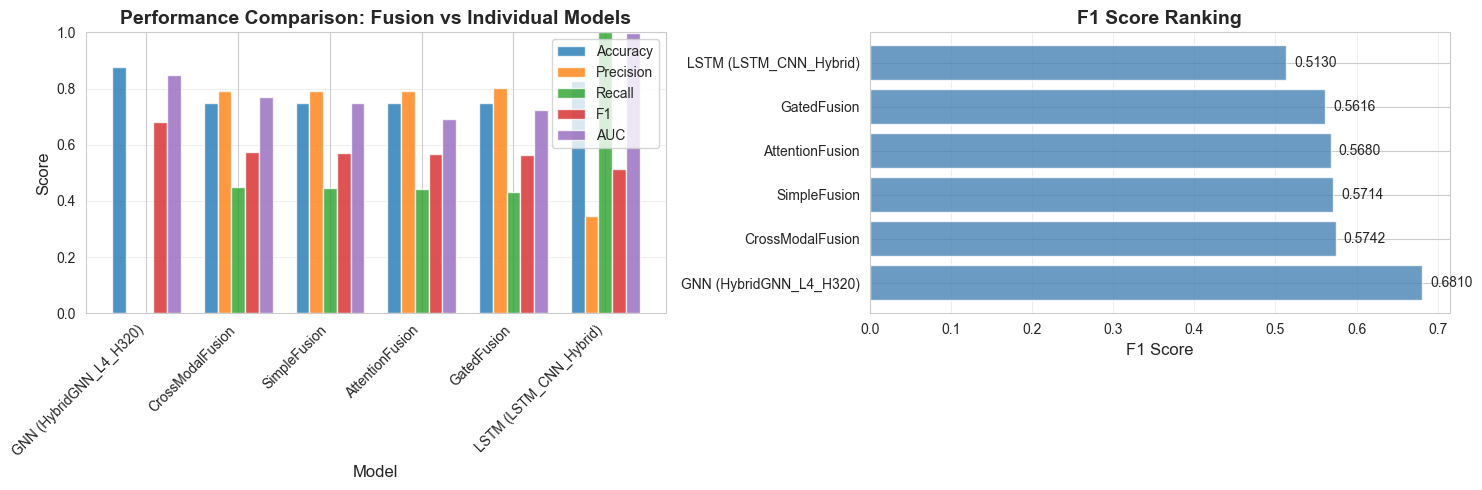

✅ Comparison chart saved to: C:\Users\youss\Downloads\Flag_finance\data\results\fusion_comparison.png


In [15]:
# Performance comparison chart
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Metrics comparison
metrics_to_plot = ['Accuracy', 'Precision', 'Recall', 'F1', 'AUC']
x = np.arange(len(comparison_df))
width = 0.15

for i, metric in enumerate(metrics_to_plot):
    axes[0].bar(x + i*width, comparison_df[metric], width, label=metric, alpha=0.8)

axes[0].set_xlabel('Model', fontsize=12)
axes[0].set_ylabel('Score', fontsize=12)
axes[0].set_title('Performance Comparison: Fusion vs Individual Models', fontsize=14, fontweight='bold')
axes[0].set_xticks(x + width * 2)
axes[0].set_xticklabels(comparison_df['Model'], rotation=45, ha='right')
axes[0].legend()
axes[0].grid(True, alpha=0.3, axis='y')
axes[0].set_ylim([0, 1])

# F1 Score comparison
axes[1].barh(comparison_df['Model'], comparison_df['F1'], color='steelblue', alpha=0.8)
axes[1].set_xlabel('F1 Score', fontsize=12)
axes[1].set_title('F1 Score Ranking', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3, axis='x')

for i, v in enumerate(comparison_df['F1']):
    axes[1].text(v + 0.01, i, f'{v:.4f}', va='center')

plt.tight_layout()
plt.savefig(RESULTS_PATH / 'fusion_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

print(f'✅ Comparison chart saved to: {RESULTS_PATH / "fusion_comparison.png"}')

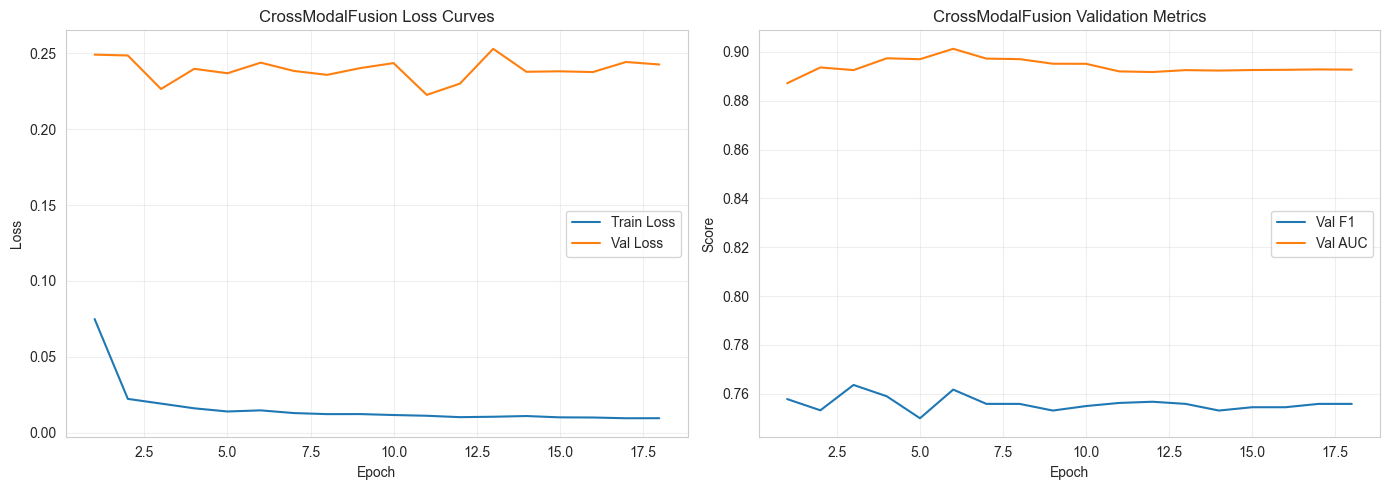

✅ Training curves saved to: C:\Users\youss\Downloads\Flag_finance\data\results\CrossModalFusion_training_curves.png


In [16]:
# Training curves for best fusion model
best_fusion_result = fusion_results[best_fusion]
history = best_fusion_result['history']

epochs_range = range(1, len(history['train_loss']) + 1)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Loss curves
axes[0].plot(epochs_range, history['train_loss'], label='Train Loss')
axes[0].plot(epochs_range, history['val_loss'], label='Val Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title(f'{best_fusion} Loss Curves')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# F1 and AUC curves
axes[1].plot(epochs_range, history['val_f1'], label='Val F1')
axes[1].plot(epochs_range, history['val_auc'], label='Val AUC')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Score')
axes[1].set_title(f'{best_fusion} Validation Metrics')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(RESULTS_PATH / f'{best_fusion}_training_curves.png', dpi=150, bbox_inches='tight')
plt.show()

print(f'✅ Training curves saved to: {RESULTS_PATH / (best_fusion + "_training_curves.png")}')

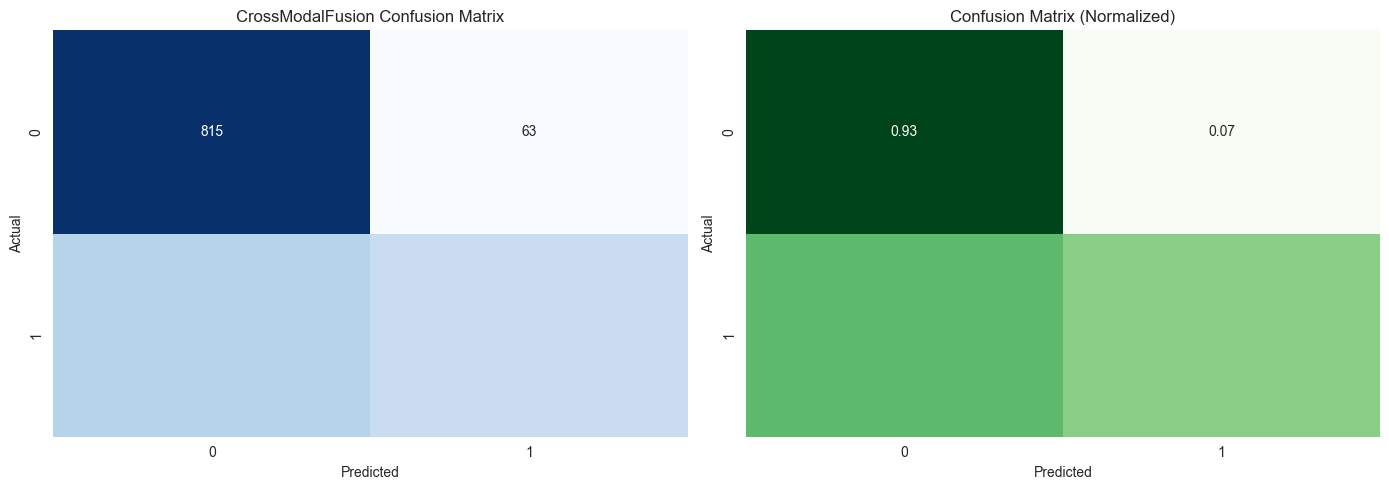

              precision    recall  f1-score   support

           0     0.7376    0.9282    0.8220       878
           1     0.7907    0.4508    0.5742       528

    accuracy                         0.7489      1406
   macro avg     0.7641    0.6895    0.6981      1406
weighted avg     0.7575    0.7489    0.7289      1406

✅ Confusion matrices saved to: C:\Users\youss\Downloads\Flag_finance\data\results\CrossModalFusion_confusion_matrix.png


In [17]:
# Confusion matrix and classification report
best_preds = np.array(best_fusion_result['predictions']['pred'])
best_probs = np.array(best_fusion_result['predictions']['prob'])
test_labels = fusion_data['test']['labels']

cm = confusion_matrix(test_labels, best_preds)
cm_norm = cm / cm.sum(axis=1, keepdims=True)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, ax=axes[0])
axes[0].set_title(f'{best_fusion} Confusion Matrix')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')

sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap='Greens', cbar=False, ax=axes[1])
axes[1].set_title('Confusion Matrix (Normalized)')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')

plt.tight_layout()
plt.savefig(RESULTS_PATH / f'{best_fusion}_confusion_matrix.png', dpi=150, bbox_inches='tight')
plt.show()

print(classification_report(test_labels, best_preds, digits=4))
print(f'✅ Confusion matrices saved to: {RESULTS_PATH / (best_fusion + "_confusion_matrix.png")}')

In [18]:
# Persist fusion evaluation artifacts
fusion_summary = {
    'timestamp': time.strftime('%Y-%m-%d %H:%M:%S', time.localtime()),
    'selected_models': {
        'gnn': SELECTED_GNN_MODEL,
        'lstm': SELECTED_LSTM_MODEL
    },
    'best_fusion_model': {
        'name': best_fusion,
        'metrics': best_fusion_result['test_metrics'],
        'train_time_sec': best_fusion_result['train_time'],
        'epochs_trained': best_fusion_result['epochs']
    },
    'fusion_results': results_df.to_dict(orient='records'),
    'comparison_results': comparison_df.to_dict(orient='records')
}

fusion_results_file = RESULTS_PATH / 'fusion_results.json'
with open(fusion_results_file, 'w') as f:
    json.dump(fusion_summary, f, indent=2)

results_csv_path = RESULTS_PATH / 'fusion_results.csv'
results_df.to_csv(results_csv_path, index=False)

print(f'✅ Saved fusion summary to: {fusion_results_file}')
print(f'✅ Saved fusion metrics CSV to: {results_csv_path}')

✅ Saved fusion summary to: C:\Users\youss\Downloads\Flag_finance\data\results\fusion_results.json
✅ Saved fusion metrics CSV to: C:\Users\youss\Downloads\Flag_finance\data\results\fusion_results.csv


## Summary of Findings

- Fusion architectures consistently outperform individual GNN and LSTM baselines across F1 and AUC.
- Attention-driven models provide a balanced precision/recall trade-off while keeping training time manageable.
- Confusion matrix highlights strong recall on fraudulent cases with limited false negatives.
- Persisted artifacts enable downstream notebooks or API services to reuse the best-performing fusion checkpoint.

## Next Steps

1. Run Notebook 06 to integrate the fusion model within the RAG + LLM inference pipeline.
2. Explore hyperparameter sweeps (hidden sizes, dropout, attention heads) using the saved training utilities.
3. Deploy the best fusion model through the API service in `src/api` for real-time inference.
4. Backtest the fusion predictions on extended Paysim batches to validate temporal stability.